<a href="https://colab.research.google.com/github/Kanakanajm/nnti/blob/main/NNTIProject%20/notebooks/task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install libraries
!pip install datasets torch transformers[torch]

In [ ]:
# libs
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from torch.cuda import empty_cache as cuda_empty_cache, mem_get_info
from gc import collect as garbage_collect
# consts
MODEL_NAME = "facebook/xglm-564M"
CACHE_DIR_DATASETS = "cache/datasets"
CACHE_DIR_TOKENIZERS = "cache/tokenizers"
CACHE_DIR_MODELS = "cache/models"

In [ ]:
# tokenizer init
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR_TOKENIZERS)

In [ ]:
# helper funcs
def clean():
    # release memory
    garbage_collect()
    cuda_empty_cache()

    mem_info = mem_get_info()
    print(f"Freeing GPU Memory\nFree: %d MB\tTotal: %d MB" % (mem_info[0] // 1024**2, mem_info[1] // 1024**2))

# set padding token to -100 in labels
def to_label_id(id):
    if (id == tokenizer.pad_token_id):
        return -100
    return id

# preprocess sentence into length 16 token chunks (w/padding)
def preprocess(batch):
    result = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=16
        # return_overflowing_tokens=True,
    )
    result['labels'] = list(map(to_label_id, result['input_ids']))

    return result

In [ ]:
def postprocess(dataset):
    return dataset.remove_columns('text').with_format('torch')

def load_task3_datasets():
    train_dataset = load_dataset("Llamacha/monolingual-quechua-iic", split="train", cache_dir=CACHE_DIR_DATASETS)
    test_dataset = load_dataset("facebook/flores", "quy_Latn", split="devtest", cache_dir=CACHE_DIR_DATASETS).remove_columns(['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink']).rename_column("sentence", "text")

    # try a smaller dataset
    train_dataset = train_dataset.select(range(8192))
    # test_dataset = test_dataset.select(range(128))

    # tokenize
    # no dynamic padding
    tokenized_train_dataset = postprocess(train_dataset.map(preprocess, batched=True))
    tokenized_test_dataset = postprocess(test_dataset.map(preprocess, batched=True))
    return tokenized_train_dataset, tokenized_test_dataset


In [ ]:
#from torch.utils.data import DataLoader

#train_dataloader = DataLoader(tokenized_dataset['train'], batch_size=16, shuffle=False)
#test_dataloader = DataLoader(tokenized_dataset['test'], batch_size=16, shuffle=False)


In [ ]:
# consts for training
DEFAULT_TRAIN_ARGS = TrainingArguments(
    output_dir="fine-tuned-xglm-564M",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    weight_decay=0.01,
    push_to_hub=False,
)

TRAIN_DATASET, TEST_DATASET = load_task3_datasets()

def get_default_trainer(model):
    return Trainer(
        model=model,
        args=DEFAULT_TRAIN_ARGS,
        train_dataset=TRAIN_DATASET,
        eval_dataset=TEST_DATASET,
    )
def get_default_model():
    return AutoModelForCausalLM.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR_MODELS).to("cuda")

# Adaptation

In [ ]:
def train_adp_model():
    # adaptation (full fine tune)
    model = get_default_model()
    get_default_trainer(model).train()


In [ ]:
clean()
train_adp_model()

# BitFit

In [ ]:
def train_bitfit_model():
    model = get_default_model()
    # bias term fine tuning
    for name, param in model.named_parameters():
        if 'bias' not in name:
            param.requires_grad = False

    get_default_trainer(model).train()


In [ ]:
clean()
train_bitfit_model()

# LoRA

In [ ]:
from functools import partial
from lora import LinearWithLoRA

In [ ]:
assign_lora = partial(LinearWithLoRA, r=8, a=16)
def train_lora_model():
    model = get_default_model()
    # low-rank adaptation
    for param in model.parameters():
        param.requires_grad = False

    for layer in model.model.layers:
        # query
        layer.self_attn.q_proj = assign_lora(layer.self_attn.q_proj)
        # value
        layer.self_attn.v_proj = assign_lora(layer.self_attn.v_proj)

    get_default_trainer(model).train()


In [ ]:
clean()
train_lora_model()

## Comparing Losses and Runtime between Fine-tuning approaches

In [1]:
import os
import numpy as np
import wandb

!wandb login

WANDB_PROJECT = "xglm-full"
LOCAL_CACHE = "../cache/"

os.environ["WANDB_API_KEY"] = ""

run_dict = {
    r"$\mathrm{(IA)}^3$": "vqibgaxq",
    "LoRA": "3gj43v4g",
    "BitFit": "3olqlgpr",
    "Full Fine-Tune": "uzp8dlt4"
}

api = wandb.Api()

train_grad_norm = { key: {"x": [], "y": []} for key in run_dict.keys()}
eval_loss = { key: {"x": [], "y": []} for key in run_dict.keys()}
eval_runtime = { key: {"x": [], "y": []} for key in run_dict.keys()}
train_loss = { key: {"x": [], "y": []} for key in run_dict.keys()}
train_runtime = { key: {"x": [], "y": []} for key in run_dict.keys()}
for run_name, run_id in run_dict.items():
    run = api.run(f"{WANDB_PROJECT}/{run_id}")
    for i, row in run.history().iterrows():
        if row["train/grad_norm"] is not None and not np.isnan(row["train/grad_norm"]):
            train_grad_norm[run_name]["x"].append(row["_step"])
            train_grad_norm[run_name]["y"].append(row["train/grad_norm"])
        
        if row["eval/loss"] is not None and not np.isnan(row["eval/loss"]):
            eval_loss[run_name]["x"].append(row["_step"])
            eval_loss[run_name]["y"].append(row["eval/loss"])
        
        if row["eval/runtime"] is not None and not np.isnan(row["eval/runtime"]):
            eval_runtime[run_name]["x"].append(row["_step"])
            eval_runtime[run_name]["y"].append(row["eval/runtime"])
        
        if row["train/loss"] is not None and not np.isnan(row["train/loss"]):
            train_loss[run_name]["x"].append(row["_step"])
            train_loss[run_name]["y"].append(row["train/loss"])

        if row["train/train_runtime"] is not None and not np.isnan(row["train/train_runtime"]):
            train_runtime[run_name]["x"].append(row["_step"])
            train_runtime[run_name]["y"].append(row["train/train_runtime"])

wandb: Currently logged in as: cama00005 (hwga-cj). Use `wandb login --relogin` to force relogin


/home/Camilo/.nntiproject/lib64/python3.10/site-packages/matplotlib/ticker.py:2927: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/home/Camilo/.nntiproject/lib64/python3.10/site-packages/matplotlib/ticker.py:2936: RuntimeWarning: invalid value encountered in multiply
  locs = (np.arange(tmin, tmax) * minorstep) + t0
/home/Camilo/.nntiproject/lib64/python3.10/site-packages/matplotlib/ticker.py:2927: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/home/Camilo/.nntiproject/lib64/python3.10/site-packages/matplotlib/ticker.py:2936: RuntimeWarning: invalid value encountered in multiply
  locs = (np.arange(tmin, tmax) * minorstep) + t0
/home/Camilo/.nntiproject/lib64/python3.10/site-packages/matplotlib/ticker.py:2927: RuntimeWarning: divide by zero encountered in scalar divide
  minorstep = majorstep / ndivs
/home/Camilo/.nntiproject/lib64/python3.10/site-packages/matplotlib/ticker.py:2936: RuntimeWarni

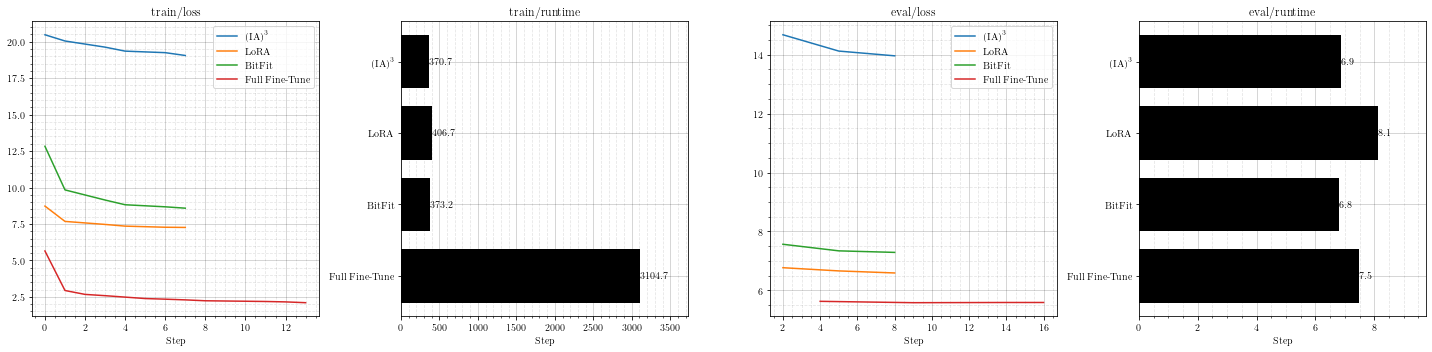

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, NullLocator
import matplotlib

# Set up figure parameters to make them look nice
plt.rcParams["axes.formatter.use_mathtext"] = True
matplotlib.rcParams["font.family"] = "cmr10"
matplotlib.rcParams["axes.unicode_minus"] = False
matplotlib.rcParams.update({"font.size": 12})
matplotlib.rcParams["figure.dpi"] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

def plot_metrics(metrics_list: list, num_cols: int, subplots: bool = True, savefig: bool = False, dpi: int = 150) -> None:
    """Plots a list of metrics, each defined as a tuple with the plotting style.

    Parameters
    ----------
    metrics_list : list
        List of tuples (metric_data, plot_type)
    num_cols: int
        Number of columns in the subplot grid
    subplots : bool
        Whether to plot in subplots (True) or individually (False)
    savefig : bool
        If provided, save the figures to files with the provided name as prefix
    """

    num_metrics = len(metrics_list)
    num_rows = -(-num_metrics // num_cols)  # Ceiling division

    if subplots:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
        axes = axes.flatten()  # Flatten in case of a single row of subplots

    for i, (metric_data, title, plot_type) in enumerate(metrics_list):
        if subplots:
            ax = axes[i]
        else:
            fig, ax = plt.subplots()

        if plot_type == "hbar":
            width = 0.75  # the width of the bars
            sorted_metric_data = []
            max_y_value = 0
            for label, data in metric_data.items():
                sorted_metric_data.append((label, np.max(data["y"])))
                max_y_value = max(max_y_value, np.max(data["y"]))

            performance = [x[1] for x in sorted_metric_data]
            labels = [x[0] for x in sorted_metric_data]
            y_pos = np.arange(len(sorted_metric_data))
            hbars = ax.barh(y_pos, performance, width, align="center", color="k")
            ax.set_yticks(y_pos, labels=labels)
            ax.invert_yaxis()  # labels read top-to-bottom
            ax.bar_label(hbars, fmt="%.1f")
            ax.set_xlim(0, max_y_value * 1.2)
        else:
            for label, data in metric_data.items():
                if plot_type == "plot":
                    ax.plot(data["x"], data["y"], label=label)
                elif plot_type == "bar":
                    ax.bar(data["x"], data["y"], label=label)
                elif plot_type == "scatter":
                    ax.scatter(data["x"], data["y"], label=label)

        if plot_type not in ("hbar", "bar"):
            ax.legend()
        ax.set_title(title)
        ax.grid(True, which="major", color="k", linestyle="-", alpha=0.2)
        ax.grid(True, which="minor", color="k", linestyle="--", alpha=0.1)
        if plot_type == "hbar":
            ax.xaxis.set_minor_locator(AutoMinorLocator()) # Enable minor ticks on x-axis
            ax.yaxis.set_minor_locator(AutoMinorLocator(n=0))  # Optionally, turn off minor ticks on y-axis
        elif plot_type == "bar":
            ax.tick_params(axis="x", which="minor", bottom=False)  # Disable minor ticks on the x-axis
        else:
            ax.minorticks_on()
        ax.set_axisbelow(True)
        ax.set_xlabel("Step")

        if savefig:
            fig.tight_layout()
            fig.savefig(os.path.join(LOCAL_CACHE, f"plots_task3/{savefig}.jpg"), dpi=dpi)

        if not subplots:
            fig.show()

    if subplots:
        # Adjust layout so labels, titles, etc. don't overlap
        fig.tight_layout()
        # Show the plot
        fig.show()


metrics_to_plot = [
    (train_loss, "train/loss", "plot"),
    (train_runtime, "train/runtime", "hbar"),
    (eval_loss, "eval/loss", "plot"),
    (eval_runtime, "eval/runtime", "hbar"),
]

plot_metrics(metrics_to_plot, num_cols=4, subplots=True, savefig="train_eval_metrics_finetuning", dpi=300)

<ipython-input-14-93cedea9d47b>:104: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


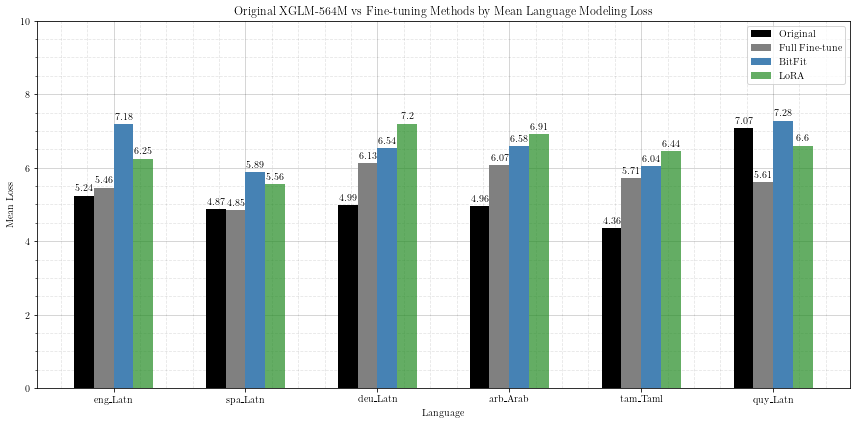

In [14]:
import json


def convert_wandb_structure(data):
    # Initialize a new dictionary to store the converted structure
    converted = {}

    # Iterate over the items in the original dictionary
    for key, value in data.items():
        # Check if the key contains 'loss'
        if "_loss" in key:
            # Extract the language and script part of the key (ignoring 'eval_' prefix and '_loss' suffix)
            lang_script = key[len("eval_") : -len("_loss")]
            # If this language_script is not yet in the converted dict, add it with an empty 'devtest' list
            if lang_script not in converted:
                converted[lang_script] = {"devtest": []}
            # Append the loss value to the 'devtest' list for this language_script
            converted[lang_script]["devtest"].append(value)

    return converted


def load_json_from(src: str, filename: str, convert_wandb: bool = False) -> dict:
    """Load JSON data from a specified file to a dictionary."""
    filename_fullpath = os.path.join(src, filename)
    if os.path.exists(filename_fullpath):
        with open(filename_fullpath, "r") as f:
            json_var = json.load(f)

        if convert_wandb:
            json_var = convert_wandb_structure(json_var)
        return json_var
    else:
        return None


def autolabel(rects: list, ax: plt.Axes) -> plt.Axes:
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(round(height, 2)),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )
    return ax


losses_xglm_filename = "losses_xglm-564M_bs_2_pbp_True_ipt_-100.json"
losses_xglm_finetuned = "losses_full-fine-tuned-xglm.json"
losses_xglm_bitfit = "loss_task1_bitfit.json"
losses_xglm_lora = "loss_task1_lora.json"

losses_xglm = load_json_from("../cache/losses", losses_xglm_filename)
losses_xglm_finetuned = load_json_from("../cache/losses", losses_xglm_finetuned)
losses_xglm_bitfit = load_json_from("../cache/losses", losses_xglm_bitfit, convert_wandb=True)
losses_xglm_lora = load_json_from("../cache/losses", losses_xglm_lora, convert_wandb=True)

LANGS_TO_CHECK = ["eng_Latn", "spa_Latn", "deu_Latn", "arb_Arab", "tam_Taml", "quy_Latn"]
split_to_plot = "devtest"

# Prepare data for plotting
labels = [lang.replace("_", "$\mathrm{\_}$") for lang in LANGS_TO_CHECK]
finetuned_losses = [np.mean(losses_xglm_finetuned[language][split_to_plot]) for language in LANGS_TO_CHECK]
xglm_losses = [np.mean(losses_xglm[language][split_to_plot]) for language in LANGS_TO_CHECK]
bitfit_losses = [np.mean(losses_xglm_bitfit[language][split_to_plot]) for language in LANGS_TO_CHECK]
lora_losses = [np.mean(losses_xglm_lora[language][split_to_plot]) for language in LANGS_TO_CHECK]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width * 2, xglm_losses, width, label="Original", color="black")
rects2 = ax.bar(x - width, finetuned_losses, width, label="Full Fine-tune", color="gray")
rects3 = ax.bar(x, bitfit_losses, width, label="BitFit", color="steelblue")
rects4 = ax.bar(x + width, lora_losses, width, label="LoRA", color="forestgreen", alpha=0.7)

# format plot
ax.set_title("Original XGLM-564M vs Fine-tuning Methods by Mean Language Modeling Loss")
ax.set_ylabel("Mean Loss")
ax.set_xlabel("Language")

group_width = width * 4
offset = width / 2  # Half the width of one bar to center the label
new_xticks = [pos - offset for pos in x]
ax.set_xticks(new_xticks)

ax.set_xticklabels(labels, ha="center")
ax.set_ylim(0, 10)
ax.legend()
ax = autolabel(rects1, ax)
ax = autolabel(rects2, ax)
ax = autolabel(rects3, ax)
ax = autolabel(rects4, ax)
ax.grid(True, which="major", color="k", linestyle="-", alpha=0.2)
ax.grid(True, which="minor", color="k", linestyle="--", alpha=0.1)
ax.tick_params(axis="x", which="minor", bottom=False)  # Disable minor ticks on the x-axis
ax.minorticks_on()
ax.set_axisbelow(True)
fig.tight_layout()
fig.show()
fig.savefig(
    os.path.join(LOCAL_CACHE, "plots_task1", "xglm_vs_all_finetuning_methods.jpg"), dpi=300, bbox_inches="tight"
)